In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
from fastai import *
from fastai.vision import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/tmp/.fastai/data/camvid/codes.txt'),
 PosixPath('/tmp/.fastai/data/camvid/labels'),
 PosixPath('/tmp/.fastai/data/camvid/valid.txt'),
 PosixPath('/tmp/.fastai/data/camvid/images')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/tmp/.fastai/data/camvid/images/0016E5_04410.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f03390.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0016E5_00660.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/tmp/.fastai/data/camvid/labels/Seq05VD_f01920_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/Seq05VD_f02610_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0001TP_007800_P.png')]

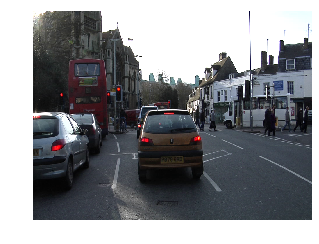

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

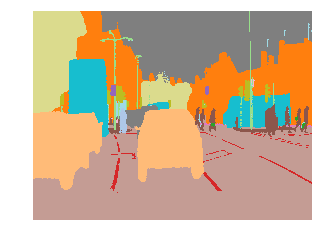

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size
bs=2

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

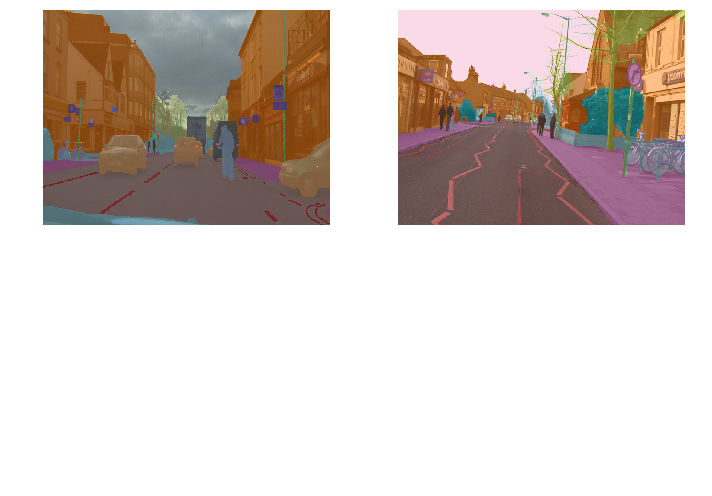

In [16]:
data.show_batch(2, figsize=(10,7))

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target!= void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics = acc_camvid

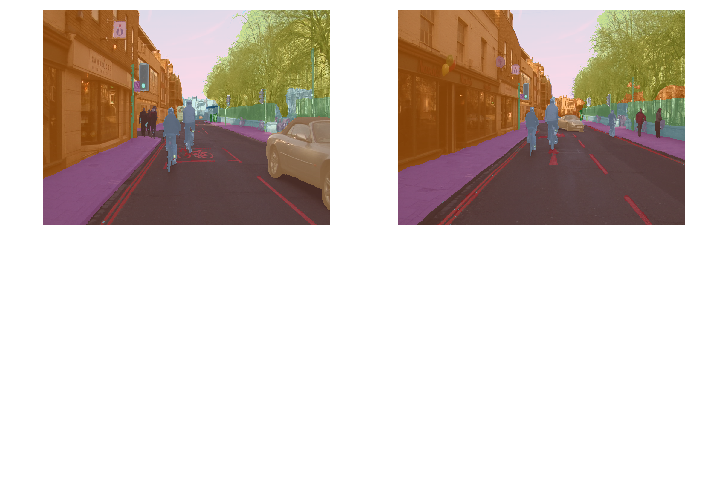

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:08<00:00, 10792071.30it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


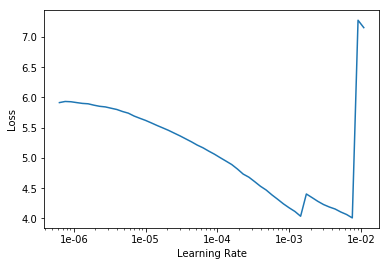

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr = 1e-5

In [23]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,3.945912,3.667586,0.011292,03:35
1,1.330760,1.192752,0.754462,03:31
2,0.908873,0.791610,0.812670,03:31
3,0.780215,0.646692,0.828856,03:31
4,0.653214,0.556425,0.848871,03:31
5,0.631531,0.511487,0.859066,03:31
6,0.607088,0.505214,0.858643,03:31
7,0.572912,0.483450,0.865111,03:31
8,0.572715,0.479039,0.864990,03:31
9,0.569825,0.464935,0.869689,03:31


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /tmp/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /tmp/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


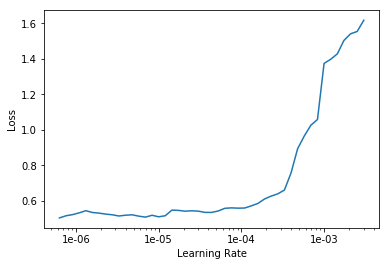

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lrs = slice(1e-5,1e-4)

In [29]:
learn.fit_one_cycle(12,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.606276,0.488995,0.862002,03:39
1,0.564252,0.436498,0.880856,03:38
2,0.540703,0.378012,0.895519,03:38
3,0.450436,0.377932,0.888312,03:39
4,0.368049,0.403021,0.892682,03:39
5,0.363462,0.361350,0.900645,03:39
6,0.309740,0.285918,0.917840,03:38
7,0.280959,0.276714,0.923228,03:39
8,0.262637,0.242994,0.929129,03:38


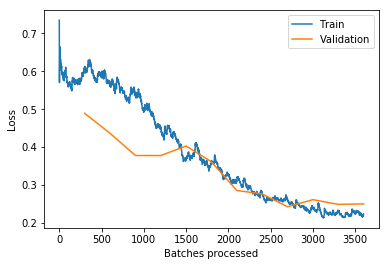

In [30]:
learn.recorder.plot_losses()

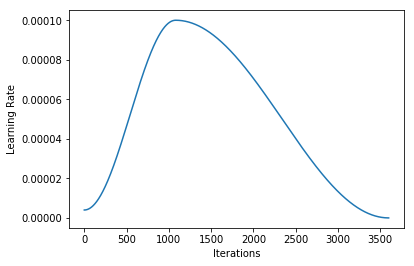

In [31]:
learn.recorder.plot_lr()

In [32]:
learn.save('stage-2')

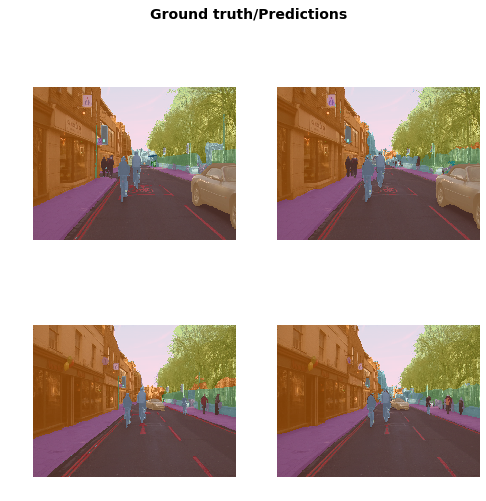

In [33]:
learn.show_results()